In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Import local modules

In [2]:
import os
import sys
module_path_lupft = '/home/glemieux/Repos/NGEET/fates/tools/landuse/src/landusepft/'
sys.path.append(module_path_lupft)
from landusepftmod import ImportLandusePFTFile, ImportStaticLUH2File
from landusepftmod import RenormalizePFTs, AddLatLonCoordinates, DefineMask
module_path_luh2 = '/home/glemieux/Repos/NGEET/fates/tools/luh2/'
sys.path.append(module_path_luh2)
from luh2mod import SetMaskSurfData, SetMaskLUH2, ImportData

### Define helper plot function

In [3]:
def plotnatpft(variable, colormap='magma_r'):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap=colormap, 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Import data

In [4]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_forest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_pasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_other_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
filelist = [clm_surface_file, clm_forest_file, clm_pasture_file, clm_other_file]

In [5]:
ds_static = ImportData(luh2_static_file)

Input file dataset opened: /home/glemieux/Data/luh2/staticData_quarterdeg.nc


In [6]:
ds_target = ImportData(regrid_target_file)

Input file dataset opened: /home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc
PrepDataset: SurfData
Surface dataset dimensions renamed for xESMF
data set updated for xESMF



In [7]:
ds_forest = ImportLandusePFTFile(clm_forest_file)

### Prep data

In [8]:
# Set the surface dataset mask
ds_target = SetMaskSurfData(ds_target)

In [9]:
# Add lat/lon coordinates for the clm5 datasets and add mask
AddLatLonCoordinates(ds_forest);
# SetMaskLUH2(ds_forest,ds_static)

<xarray.Dataset>
Dimensions:      (natpft: 15, cft: 64, lon: 1440, lat: 720)
Coordinates:
  * natpft       (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft          (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables: (12/13)
    EDGEN        float64 90.0
    EDGEE        float64 180.0
    EDGES        float64 -90.0
    EDGEW        float64 -180.0
    LAT          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    LATIXY       (lat, lon) float32 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    ...           ...
    LONGXY       (lat, lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    LANDMASK     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    LANDFRAC     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    AREA         (lat, lon) float32 3.379 3.379 3.379 ... 4.742e-14 4.742e-14
    PCT_NAT_PFT  (natpft, lat, lon) float64 100.0 100.0 100.0 ... 0.0 0.0 0.0
    mask         (lat, lon) bool False False False False ... False False False
Attributes:
    source:         Peter Lawrence, NCAR
    creation_date:  Thu Jun 15 14:53:15 MDT 2017
    title:          CLM5_current_luhforest_deg025.nc

### Start percentage list and calculate bareground percentage

In [10]:
percent_bareground = ds_forest.PCT_NAT_PFT.isel(natpft=0)
percent_bareground = (percent_bareground / 100.0)

### Renormalized CLM5 data and mask data

In [11]:
percent_forest = RenormalizePFTs(ds_forest)

In [12]:
ds_percent_forest = percent_forest.to_dataset()

In [18]:
SetMaskLUH2(ds_percent_forest, ds_static)

<xarray.Dataset>
Dimensions:      (natpft: 14, lon: 1440, lat: 720)
Coordinates:
  * natpft       (natpft) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    PCT_NAT_PFT  (natpft, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    mask         (lat, lon) bool False False False False ... False False False

### Calculate the primary and secondary PFT fractions as the forest

In [19]:
# Skip this for now
# percent[2] = ds_static.fstnf * percent[2] + (1. - ds_static.fstnf) * percent[-1]

### Regrid the dataset

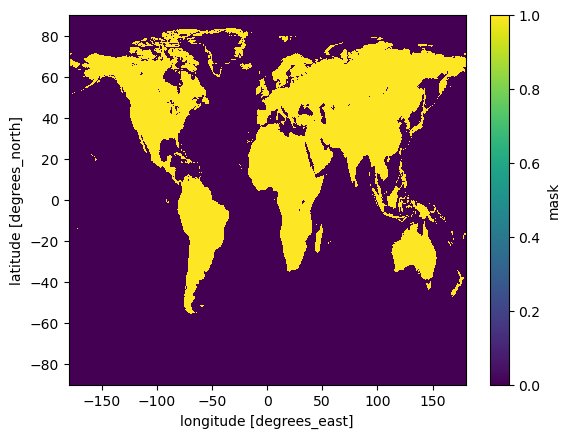

In [22]:
ds_percent_forest.mask.plot()

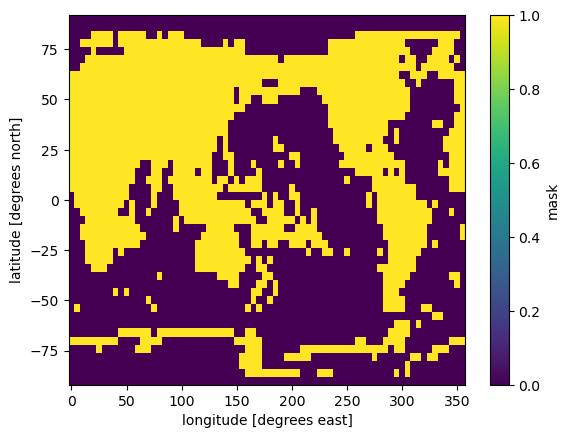

In [23]:
ds_target.mask.plot()

In [24]:
regridder = xe.Regridder(ds_percent_forest, ds_target, "conservative")
# regridder = xe.Regridder(ds_percent, ds_target, "conservative_normed")
ds_regrid = regridder(ds_percent_forest)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


### Review the regridded data

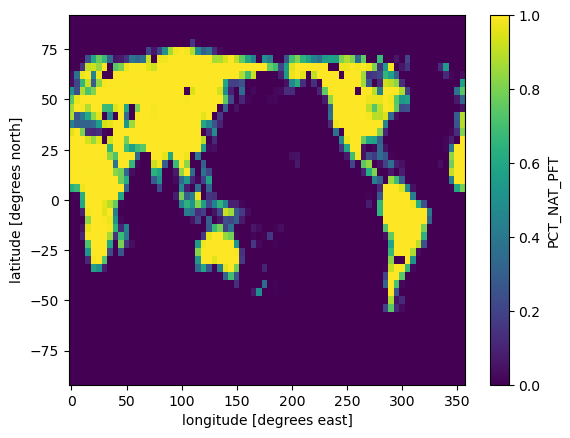

In [25]:
ds_regrid.PCT_NAT_PFT.sum(dim='natpft').plot()